# Классификация текстов

Мы будем работать с датасетом объявлений Avito. Нам предстоит по заголовку и тексту объявления предсказывать категорию объявления.

In [1]:
import pandas as pd

In [2]:
import os
from google.colab import drive
 
drive.mount('/content/drive')
 
data_root = '/content/drive/MyDrive/Colab Notebooks/avito-text-classification'
os.environ['DATA_ROOT'] = data_root
 
print('Data root:', data_root)
print('Data root contains:', os.listdir(data_root))

Mounted at /content/drive
Data root: /content/drive/MyDrive/Colab Notebooks/avito-text-classification
Data root contains: ['train.csv', 'test.csv', 'sample_submission.csv']


In [3]:
train = pd.read_csv(os.path.join(data_root, 'train.csv'))

In [4]:
train.head()

,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


In [5]:
train.shape

(4234042, 4)

## Выведем на экран информацию о пропусках в данных.

In [ ]:
train.isna().sum()

title            0
description      2
Category_name    0
Category         0
dtype: int64

In [ ]:
train.fillna('',inplace=True)

In [ ]:
train.isna().sum()

title            0
description      0
Category_name    0
Category         0
dtype: int64

## Сконкатенируем заголовок и описание

In [6]:
train = train.assign(title_description = train.title + " " + train.description)

In [7]:
del train['title']
del train['description']

In [8]:
train.head()

,Category_name,Category,title_description
0,Запчасти и аксессуары,10,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 ..."
1,Бытовая техника,21,Утюг утп 1000 ватт СССР 1987 год Продам/\n Фот...
2,Предложение услуг,114,Возвму машину с выкупом Возьму машину в аренду...
3,"Одежда, обувь, аксессуары",27,"Полусапожки полусапожки в отличном состоянии, ..."
4,"Одежда, обувь, аксессуары",27,Босоножки кожаные Кожаные(натур) босоножки Kar...


## Посмотрим на данные

In [ ]:
train['Category'].nunique()

50

In [26]:
import numpy as np
unique, counts = np.unique(train['Category_name'], return_counts=True)
counts = counts / counts.sum() * 100

In [27]:
df = pd.DataFrame(data=(unique,counts), index=['Класс', 'Доля в %']).T

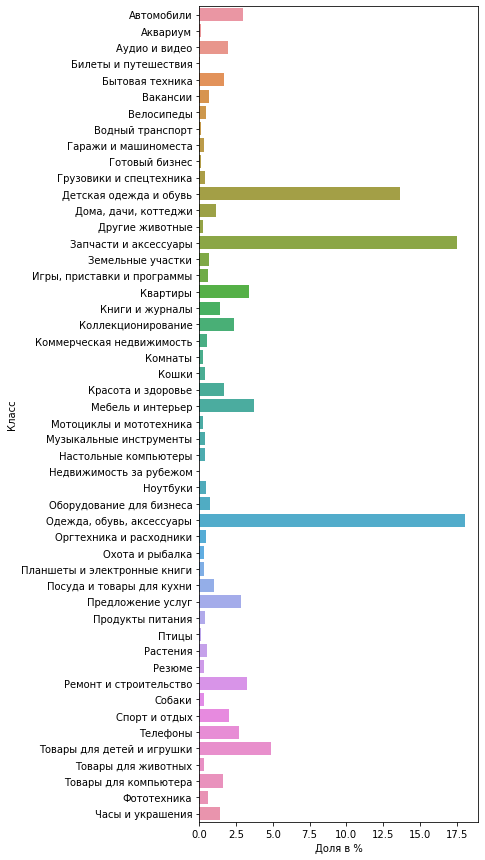

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(5, 15))
sns.barplot(x ='Доля в %', y ='Класс', data= df)

In [ ]:
df['Доля в %']= pd.to_numeric(df['Доля в %'])

In [ ]:
df.iloc[df['Доля в %'].argmax()]

Класс       Одежда, обувь, аксессуары
Доля в %                      18.0707
Name: 31, dtype: object

In [ ]:
df.iloc[df['Доля в %'].argmin()]

Класс       Недвижимость за рубежом
Доля в %                 0.00389699
Name: 28, dtype: object

### Тест CountVectorizer


In [29]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vec = CountVectorizer()

In [ ]:
bow = vec.fit_transform(train['title_description'])

In [ ]:
bow.shape

(4234042, 2125805)

## Посмотрим на словарь

In [ ]:
import re
words = list(vec.vocabulary_.keys())
words = ' '.join(words)

In [ ]:
result1 = re.findall(r'\b\d+\S+\b',words)

In [ ]:
len(result1)

610889

In [ ]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
result2 = re.findall(r'\b[!"#$%&\'()*+,-./:;<=>?@\[\\\]^_`{|}~]\S*\b',words)

In [ ]:
len(result2)

2043

## Кастомный токенайзер.
0. Приводит все буквы к нижнему регистру
1. Разбивает текст на токены с помощью word_tokenizer из пакета nltk
2. Удаляет все токены содержащие числа и пунктуацию
3. Удаляет все токены, которые перечислены в nltk.corpus.stopwords('russian')
4. Проводит стемминг с помощью SnowballStemmer


In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
stemmer = SnowballStemmer('russian')

In [17]:
def mytokenizer(text):
  text = re.sub(r'\b\S*\d+\S*\b',' ',text)
  text = re.sub(r'\S*[!"#$%&\'()*+,-./:;<=>?@\]\[\\^_`{|}~»«—_]\S*',' ',text)
  text = re.sub(r'\s+',' ',text)
  text = word_tokenize(text.lower())
  text = np.array(text)[np.in1d(text,np.array(stopwords.words('russian')),invert=True)]
  text = [stemmer.stem(word) for word in text]
  return text

In [20]:
mytokenizer(train['title_description'][0])

['эб',
 'renault',
 'nissa',
 'dci',
 'delph',
 'год',
 'комплект',
 'эб',
 'компьютер',
 'электрон',
 'блок',
 'управлен',
 'двигател',
 'рен',
 'kango',
 'lagun',
 'cli',
 'nissa',
 'micr',
 'друг',
 'рен',
 'нисса',
 'дизел',
 'топливн',
 'аппаратур',
 'отличн',
 'проверен',
 'запчаст',
 'предоставля',
 'возможн',
 'подробн',
 'раздел',
 'дорож',
 'сво',
 'репутац',
 'торгу',
 'легальн',
 'контрактн',
 'запчаст',
 'дета',
 'налич',
 'таможен',
 'запчаст',
 'автомобил',
 'пробег',
 'отправля',
 'друг',
 'регион',
 'таможен',
 'союз',
 'транспортн',
 'компан',
 'наложн']

### Проверим быстродействие различных функций

In [21]:
test_text = re.sub(r'\b\S*\d+\S*\b',' ',train['title_description'][0])
test_text = re.sub(r'\S*[!"#$%&\'()*+,-./:;<=>?@\]\[\\^_`{|}~»«—_]\S*',' ',test_text)
test_text = re.sub(r'\s+',' ',test_text)
test_text = word_tokenize(test_text.lower())

In [22]:
%%time
test_text1 = np.array(test_text)[np.in1d(test_text,np.array(stopwords.words('russian')),invert=True)]
test_text1 = [stemmer.stem(word) for word in test_text]

CPU times: user 3.79 ms, sys: 0 ns, total: 3.79 ms
Wall time: 3.79 ms


In [23]:
%%time
test_text2 = [stemmer.stem(word) for word in test_text if word not in stopwords.words('russian')]

CPU times: user 15 ms, sys: 1.21 ms, total: 16.2 ms
Wall time: 20.3 ms


In [24]:
%%time
stemmedtext=[]
for word in test_text:
  if word not in stopwords.words('russian'):
    stemmedtext.append(stemmer.stem(word))

CPU times: user 9.55 ms, sys: 2.11 ms, total: 11.7 ms
Wall time: 11.9 ms


## Обучение с CountVectorizer
1. Возьмем случайные 100к строк из датасета. Построим по ним CountVectorizer.
2. Разбиваем полученную матрицу на train, test в отношении 4 к 1.
3. Обучим SGDClassifier на полученной выборке.
4. Считаем accuracy

In [30]:
vec = CountVectorizer(tokenizer = mytokenizer)
sam = train.sample(n=100000)
del train#чтобы в колабе ОЗУ не переполнялось

In [31]:
bow = vec.fit_transform(sam['title_description'])

In [32]:
bow.shape

(100000, 74902)

In [33]:
%%time
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, sam['Category'], random_state=13, test_size=0.2, train_size=0.8)

CPU times: user 21.4 ms, sys: 1.02 ms, total: 22.4 ms
Wall time: 24.9 ms


In [34]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
sgd = SGDClassifier(max_iter = 200, random_state=13)
sgd.fit(x_train,y_train)

CPU times: user 8.02 s, sys: 4.87 s, total: 12.9 s
Wall time: 7.07 s


In [35]:
pred = sgd.predict(x_test)

In [36]:
print(accuracy_score(y_test,pred))

0.80835


## Обучение с TfIdfVectorizer



In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(tokenizer = mytokenizer,max_df=0.9)

In [38]:
%%time
bow = tfidf_vec.fit_transform(sam['title_description'])

CPU times: user 2min 50s, sys: 2.45 s, total: 2min 52s
Wall time: 2min 52s


In [39]:
%%time
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, sam['Category'], random_state=13, test_size=0.2, train_size=0.8)

CPU times: user 19.7 ms, sys: 986 µs, total: 20.7 ms
Wall time: 21.4 ms


In [40]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
sgd = SGDClassifier(max_iter = 200, random_state=13)
sgd.fit(x_train,y_train)

CPU times: user 5.09 s, sys: 3.46 s, total: 8.55 s
Wall time: 4.37 s


In [41]:
pred = sgd.predict(x_test)

In [42]:
print(accuracy_score(y_test,pred))

0.8089


## Hashing trick


In [43]:
from sklearn.feature_extraction.text import HashingVectorizer
hash_vec = HashingVectorizer(tokenizer = mytokenizer, n_features=30000)

In [44]:
bow = hash_vec.fit_transform(sam['title_description'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [45]:
bow.shape

(100000, 30000)

In [46]:
%%time
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, sam['Category'], random_state=13, test_size=0.2, train_size=0.8)

CPU times: user 19.3 ms, sys: 1.02 ms, total: 20.3 ms
Wall time: 19.8 ms


In [47]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
sgd = SGDClassifier(max_iter = 200, random_state=13)
sgd.fit(x_train,y_train)

CPU times: user 4.8 s, sys: 3.35 s, total: 8.15 s
Wall time: 4.2 s


In [48]:
pred = sgd.predict(x_test)
print(accuracy_score(y_test,pred))

0.7915
